# **Integer Constrained Optimization: A Real Use Case**
## **A cafeteria in Munich**

Problem statement

# 0. Environment preparation

In [1]:
#importing the needed libraries

import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import random
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs



## 1. Capturing our weather data

Introduce how we get our weather data

In [2]:
#Calculate one week ago weather (the end point does not allow to retrieve data for last 7 days)
yesterday = datetime.now() - timedelta(days=7)
end_date = yesterday.strftime("%Y-%m-%d")


#API call
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 48.14,
    "longitude": 11.58,
    "start_date": "2022-01-01",
    "end_date": end_date,
    "hourly": "temperature_2m",
    "min": "2023-05-25",
    "max": "2023-06-08"
}

response = requests.get(url, params=params)

#Getting hourly data into a dataframe
if response.status_code == 200:
    data = response.json()
    hourly_data = data['hourly']
    df = pd.DataFrame(hourly_data)
    
    #Splitting time into date and hour columns
    df[['date', 'hour']] = df['time'].str.split('T', expand=True)

    print(df)
else:
    print("Failed to retrieve data. Status code:", response.status_code)

                   time  temperature_2m        date   hour
0      2022-01-01T00:00             8.5  2022-01-01  00:00
1      2022-01-01T01:00             7.9  2022-01-01  01:00
2      2022-01-01T02:00             7.5  2022-01-01  02:00
3      2022-01-01T03:00             7.0  2022-01-01  03:00
4      2022-01-01T04:00             7.3  2022-01-01  04:00
...                 ...             ...         ...    ...
12523  2023-06-06T19:00            17.1  2023-06-06  19:00
12524  2023-06-06T20:00            15.5  2023-06-06  20:00
12525  2023-06-06T21:00            14.5  2023-06-06  21:00
12526  2023-06-06T22:00            14.0  2023-06-06  22:00
12527  2023-06-06T23:00            13.4  2023-06-06  23:00

[12528 rows x 4 columns]


In [3]:
#Now, we drop with hour and with time columns, and also (just in case) rows with NaN values
df.drop(['hour', 'time'], axis=1, inplace=True)
df.dropna(inplace=True)

In [4]:
#We convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

#Now, we group by date and we calculate mean temperature
df = df.groupby('date')['temperature_2m'].mean().reset_index()

print(df)

          date  temperature_2m
0   2022-01-01        7.245833
1   2022-01-02        6.966667
2   2022-01-03        8.720833
3   2022-01-04        8.516667
4   2022-01-05        1.800000
..         ...             ...
517 2023-06-02       17.337500
518 2023-06-03       16.375000
519 2023-06-04       16.300000
520 2023-06-05       15.891667
521 2023-06-06       15.662500

[522 rows x 2 columns]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            522 non-null    datetime64[ns]
 1   temperature_2m  522 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.3 KB


In [6]:
#Change temperature_2m column name to avg_temperature
df.rename(columns={'temperature_2m': 'avg_temperature'}, inplace=True)

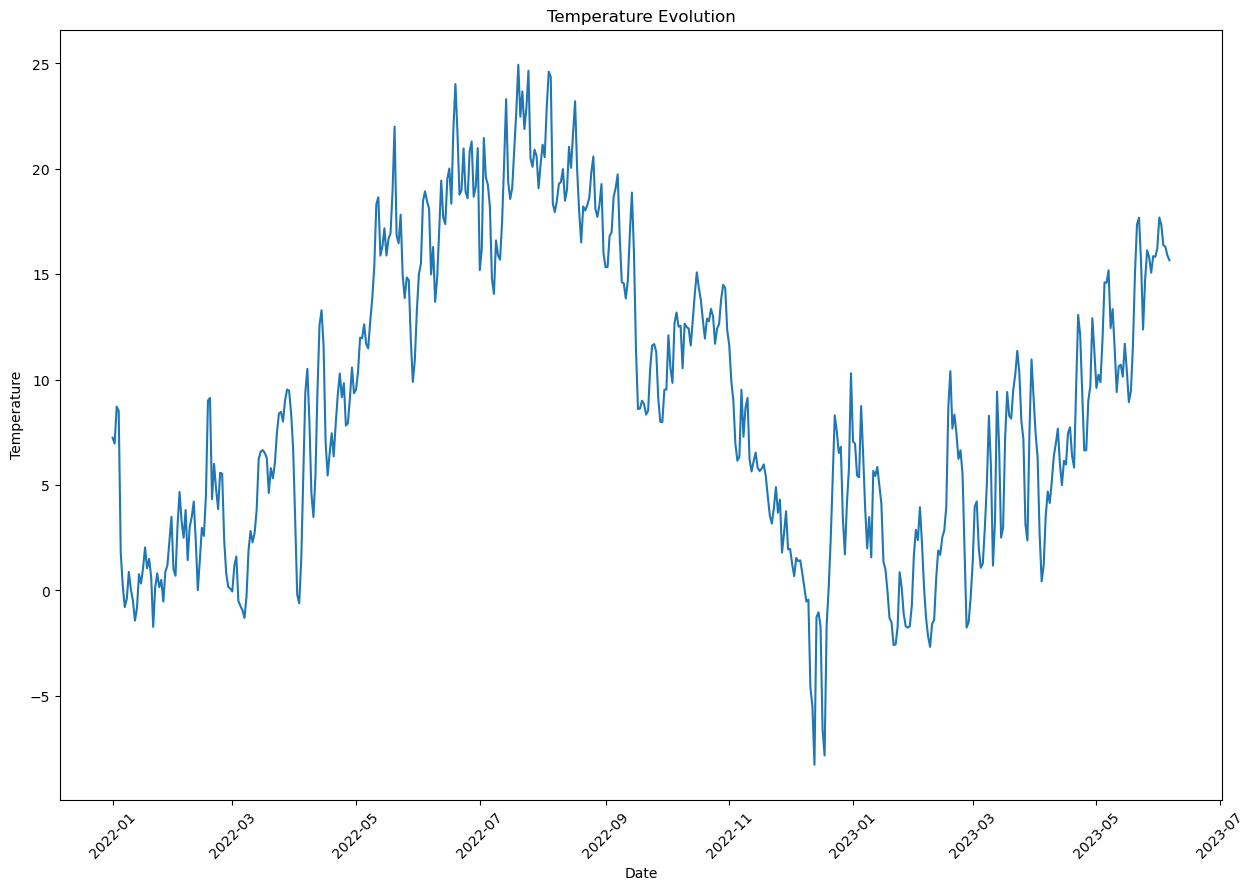

In [7]:
#Let's plot the temperature evolution in Munich
plt.figure(figsize=(15, 10))
plt.plot(df['date'], df['avg_temperature'])


# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Evolution')
plt.xticks(rotation=45)

# Display the plot
plt.show()

# 2. Time Series Analysis and Forecast

Introduce the section

In [8]:
#We check for stationarity
result = adfuller(df['avg_temperature'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Tests
s = 365
d = ndiffs(df['avg_temperature'], alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(df['avg_temperature'], m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF Statistic: -1.891529748979712
p-value: 0.33605621580186357
Regular differences:  1
Seasonal differences: 0


As we can see, our p-value is bigger than our treshold, 0.05, so we have to apply a difference and check again, in order to make our data stationary

In [9]:
# Differencing to make the data stationary
df['diff_temperature'] = df['avg_temperature'].diff().fillna(0)

# Check for stationarity after differencing
result_diff = adfuller(df['diff_temperature'])
print("ADF Statistic (after differencing):", result_diff[0])
print("p-value (after differencing):", result_diff[1])

ADF Statistic (after differencing): -14.381166425188782
p-value (after differencing): 9.147893368843764e-27


Now, our data is stationary, so we can further proceed

In [10]:
# Splitting the data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

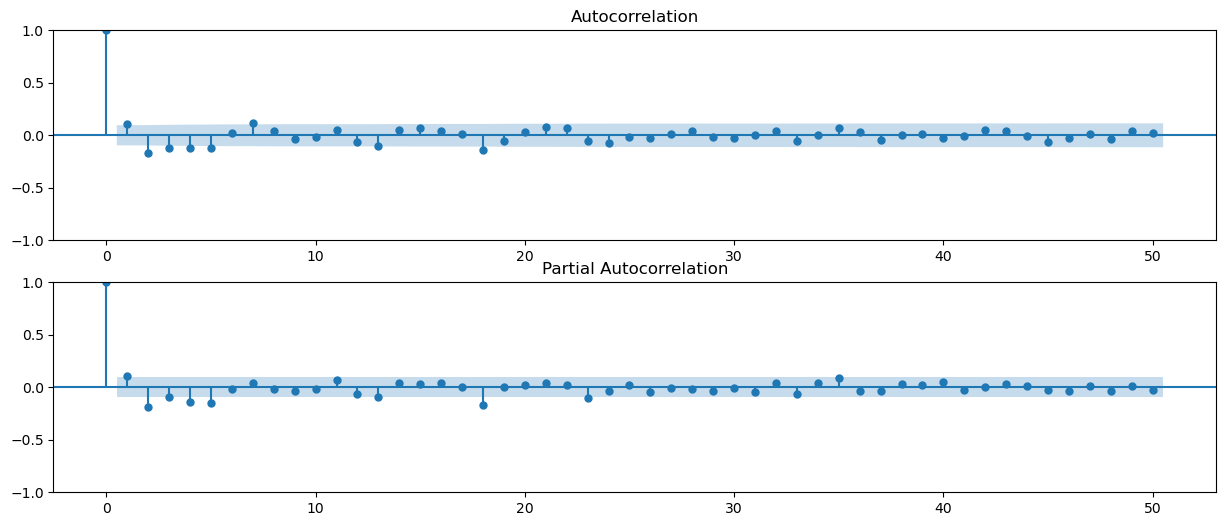

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 50 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(train['diff_temperature'], lags = nlags, ax=ax[0])
plot_pacf(train['diff_temperature'], lags = nlags, method="ols", ax=ax[1])
plt.show()

In [18]:
#Apply an auto_arima model
model = pmdarima.auto_arima(train['diff_temperature'], seasonal=True, m=365, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[365] intercept   : AIC=inf, Time=619.61 sec
 ARIMA(0,0,0)(0,0,0)[365] intercept   : AIC=1691.359, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[365] intercept   : AIC=inf, Time=112.40 sec
 ARIMA(0,0,1)(0,0,1)[365] intercept   : AIC=inf, Time=109.58 sec
 ARIMA(0,0,0)(0,0,0)[365]             : AIC=1689.359, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[365] intercept   : AIC=inf, Time=100.41 sec
 ARIMA(0,0,0)(0,0,1)[365] intercept   : AIC=inf, Time=115.59 sec
 ARIMA(0,0,0)(1,0,1)[365] intercept   : AIC=inf, Time=112.14 sec
 ARIMA(1,0,0)(0,0,0)[365] intercept   : AIC=1688.646, Time=2.65 sec


MemoryError: Unable to allocate 427. MiB for an array with shape (366, 366, 418) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1015, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 427. MiB for an array with shape (366, 366, 418) and data type float64


: 

: 

# 3. Integer constrained optimization apply to our demand

Introduction

In [12]:
def get_demands_by_temperature(temperature_celsius):
    global wine_demand
    global ice_cream_demand
    global coffee_demand
    
    if temperature_celsius <= 10:
        wine_demand = random.randint(70, 90)
        ice_cream_demand = random.randint(1, 10)
        coffee_demand = random.randint(50, 70)
    elif temperature_celsius > 10 and temperature_celsius <= 20:
        wine_demand = random.randint(20, 40)
        ice_cream_demand = random.randint(15, 25)
        coffee_demand = random.randint(70, 90)
    elif temperature_celsius > 20:
        wine_demand = random.randint(1, 10)
        ice_cream_demand = random.randint(70, 90)
        coffee_demand = random.randint(30, 50)

    return wine_demand, ice_cream_demand, coffee_demand

In [13]:
# Apply the function to the DataFrame and create new columns for demand
df[['wine_demand', 'ice_cream_demand', 'coffee_demand']] = df['avg_temperature'].apply(lambda x: pd.Series(get_demands_by_temperature(x)))

# Display the updated DataFrame
print(df)

          date  avg_temperature  diff_temperature  wine_demand  \
0   2022-01-01         7.245833          0.000000           72   
1   2022-01-02         6.966667         -0.279167           74   
2   2022-01-03         8.720833          1.754167           84   
3   2022-01-04         8.516667         -0.204167           90   
4   2022-01-05         1.800000         -6.716667           80   
..         ...              ...               ...          ...   
517 2023-06-02        17.337500         -0.354167           25   
518 2023-06-03        16.375000         -0.962500           32   
519 2023-06-04        16.300000         -0.075000           28   
520 2023-06-05        15.891667         -0.408333           25   
521 2023-06-06        15.662500         -0.229167           39   

     ice_cream_demand  coffee_demand  
0                   3             51  
1                   4             59  
2                   6             56  
3                  10             64  
4           

In [14]:
#here, cafe owner can introduce a date and we retrieve the demand for that day, for each product

In [15]:
#apply our pyomo model

In [16]:
#retrieve recommendations for the cafe owner